In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
from torchvision import transforms

In [ ]:
import os
import pandas as pd

def create_dataframe(root_folder):
    data = {'image_path': [], 'mask_path': [], 'label': []}

    for disease in ['BCC', 'SCC', 'IEC']:
        image_dir = os.path.join(root_folder, disease, 'Images')
        mask_dir = os.path.join(root_folder, disease, 'Masks')

        for img_file in os.listdir(image_dir):
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, img_file)  # Assuming masks have a similar naming convention

            data['image_path'].append(img_path)
            data['mask_path'].append(mask_path)
            data['label'].append(disease)

    df = pd.DataFrame(data)
    return df

# Create the DataFrame
root_folder = 'Queensland Dataset CE42'
df = create_dataframe(root_folder)
df

,image_path,mask_path,label
0,Queensland Dataset CE42/BCC/Images/BCC_24_0003...,Queensland Dataset CE42/BCC/Masks/BCC_24_0003.png,BCC
1,Queensland Dataset CE42/BCC/Images/BCC_38_0006...,Queensland Dataset CE42/BCC/Masks/BCC_38_0006.png,BCC
2,Queensland Dataset CE42/BCC/Images/BCC_11_0001...,Queensland Dataset CE42/BCC/Masks/BCC_11_0001.png,BCC
3,Queensland Dataset CE42/BCC/Images/BCC_39_0012...,Queensland Dataset CE42/BCC/Masks/BCC_39_0012.png,BCC
4,Queensland Dataset CE42/BCC/Images/BCC_39_0006...,Queensland Dataset CE42/BCC/Masks/BCC_39_0006.png,BCC
...,...,...,...
1495,Queensland Dataset CE42/IEC/Images/IEC_48_0001...,Queensland Dataset CE42/IEC/Masks/IEC_48_0001.png,IEC
1496,Queensland Dataset CE42/IEC/Images/IEC_48_0015...,Queensland Dataset CE42/IEC/Masks/IEC_48_0015.png,IEC
1497,Queensland Dataset CE42/IEC/Images/IEC_49_0001...,Queensland Dataset CE42/IEC/Masks/IEC_49_0001.png,IEC
1498,Queensland Dataset CE42/IEC/Images/IEC_60_0006...,Queensland Dataset CE42/IEC/Masks/IEC_60_0006.png,IEC


In [ ]:
color_to_class = {
    (108, 0, 115): 0,    # Glands
    (145, 1, 122): 1,    # Inflammation
    (216, 47, 148): 2,   # Hair Follicle
    (254, 246, 242): 3,  # Hypodermis
    (181, 9, 130): 4,    # Reticular Dermis
    (236, 85, 157): 5,   # Papillary Dermis
    (73, 0, 106): 6,     # Epidermis
    (248, 123, 168): 7,  # Keratin
    (0, 0, 0): 8,        # Background
    (127, 255, 255): 9,  # Basal Cell Carcinoma
    (127, 255, 142): 10, # Squamous Cell Carcinoma
    (255, 127, 127): 11  # Intra-epidermal Carcinoma
}

In [ ]:
color_to_class = {
    (108, 0, 115): 0,    # Glands
    (145, 1, 122): 1,    # Inflammation
    (216, 47, 148): 2,   # Hair Follicle
    (254, 246, 242): 3,  # Hypodermis
    (181, 9, 130): 4,    # Reticular Dermis
    (236, 85, 157): 5,   # Papillary Dermis
    (73, 0, 106): 6,     # Epidermis
    (248, 123, 168): 7,  # Keratin
    (0, 0, 0): 8,        # Background
    (127, 255, 255): 9,  # Basal Cell Carcinoma
    (127, 255, 142): 10, # Squamous Cell Carcinoma
    (255, 127, 127): 11  # Intra-epidermal Carcinoma
}

# Function to convert RGB mask to class indices
def rgb_to_class_index(mask):
    mask_np = np.array(mask)  # Convert mask to numpy array
    class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)

    for rgb, class_idx in color_to_class.items():
        matches = np.all(mask_np == rgb, axis=-1)
        class_mask[matches] = class_idx

    return torch.from_numpy(class_mask)


class QueenslandDatasetFromDF(Dataset):
    def __init__(self, df, transform=None, mask_transform=None):
        self.df = df
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        mask_path = self.df.iloc[idx]['mask_path']

        # Load images and masks
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Apply transformations to the image if provided
        class_mask = rgb_to_class_index(mask)
        if self.transform:
            image = self.transform(image)
            # class_mask = self.transform(class_mask)

        return image, class_mask

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Create datasets and loaders
train_dataset = QueenslandDatasetFromDF(train_df, transform=transform)
test_dataset = QueenslandDatasetFromDF(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
for img, mask in train_loader:
    print(img.shape, mask.shape)
    break

torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=12):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Expanding Path)
        self.upconv4 = self.upconv_block(1024, 512)
        self.decoder4 = self.conv_block(1024, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.decoder3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.decoder2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.decoder1 = self.conv_block(128, 64)

        # Final Convolution to get the desired output channels
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder Path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder Path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output
        return self.final_conv(dec1)

# Initialize and print model
model = UNet(in_channels=3, out_channels=12)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [ ]:
# Model, loss, and optimizer
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=12).to(device)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss combines log softmax and NLL loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='mps'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        epoch_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks.long())  # Ensure masks are long for CrossEntropyLoss

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # Evaluate on test set and print accuracy
        test_accuracy = test(model, test_loader, device)
        print(f"Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%")

        # Plot a sample from test set
        plot_sample(model, test_loader, device)

def test(model, dataloader, device='mps'):
    model.eval()  # Set model to evaluation mode
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Get predicted class for each pixel
            _, predicted = torch.max(outputs, 1)

            # Calculate accuracy
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = 100 * correct_pixels / total_pixels
    return accuracy

def plot_sample(model, dataloader, device='mps'):
    model.eval()

    # Get a sample batch from the test dataloader
    images, masks = next(iter(dataloader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Move data to CPU for plotting
    images = images.cpu()
    masks = masks.cpu()
    predicted = predicted.cpu()

    # Plot the first image, true mask, and predicted mask
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images[0].permute(1, 2, 0))  # Show input image
    axs[0].set_title("Input Image")
    axs[1].imshow(masks[0])  # Show true mask
    axs[1].set_title("True Mask")
    axs[2].imshow(predicted[0])  # Show predicted mask
    axs[2].set_title("Predicted Mask")
    for ax in axs:
        ax.axis("off")
    plt.show()


Epoch 1/20: 100%|███████████████████████████████| 85/85 [04:53<00:00,  3.45s/it]


Epoch [1/20], Loss: 1.4503
Test Accuracy after Epoch 1: 76.79%


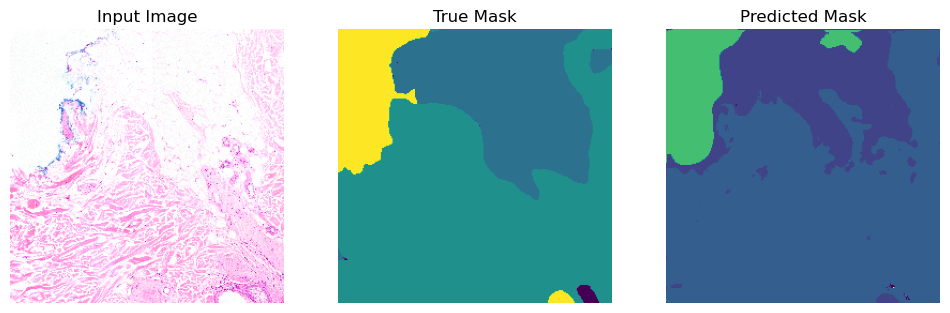

Epoch 2/20:  12%|███▋                           | 10/85 [00:41<05:11,  4.15s/it]

In [ ]:
# Check device
from tqdm import tqdm

# Run training loop
num_epochs = 20
train(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, device=device)
